# Assignment on Donor Choose

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website. 

Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve: 
• How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible
•How to increase the consistency of project vetting across different volunteers to improve the experience for teachers
•How to focus volunteer time on the applications that need the most assistance


The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval

Attirbutes in the train.csv- 1) project_id 2) project_title 3) project_grade_category 4) project_subject_categories 5) school_state 6)
project_subject_subcategories 7) project_resource_summary 8) project_essay_1 9) project_essay_2 10) project_essay_3 11)
project_essay_4 12) projecct_submitted_datetime 13) teacher_id 14) teacher_prefix
15)teacher_number_of_previously_posted_project
Attributes in resource.csv - Additionally, the resources.csv data set provides more data about the resources required for each project.
Each line in this file represents a resource required by a project: 1) id - A project_id value from the train.csv file. 2) description -
Desciption of the resource. 3) quantity - Quantity of the resource required. 4) price - Price of the resource required.
The data set contains the following label:
project_is_approved - A binary flag indicating whether DonorsChoose approved the project. A value of 0 indicates the project was not
approved, and a value of 1 indicates the project was approved.


In [1]:
Here we importing bunch of libraries to perform Univariate analysis
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


#https://plot.ly/python/getting-started-with-chart-studio/

import chart_studio.plotly as py

from collections import Counter

# 1.1 Reading the Data

In [2]:
#we are loading two datas in pandas dataframe
project_data = pd.read_csv(r'C:\Users\SAI\Downloads\Assignment_donorchoose 2018\train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)
project_data.head(3)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0


here we have 109248 projects and 17 different attributes i.e.'teacher_id' 'teacher_prefix' 'school_state''project_submitted_datetime' 'project_grade_category' and others


In [4]:
project_data.dtypes

Unnamed: 0                                       int64
id                                              object
teacher_id                                      object
teacher_prefix                                  object
school_state                                    object
project_submitted_datetime                      object
project_grade_category                          object
project_subject_categories                      object
project_subject_subcategories                   object
project_title                                   object
project_essay_1                                 object
project_essay_2                                 object
project_essay_3                                 object
project_essay_4                                 object
project_resource_summary                        object
teacher_number_of_previously_posted_projects     int64
project_is_approved                              int64
dtype: object

In [5]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 17 columns):
Unnamed: 0                                      109248 non-null int64
id                                              109248 non-null object
teacher_id                                      109248 non-null object
teacher_prefix                                  109245 non-null object
school_state                                    109248 non-null object
project_submitted_datetime                      109248 non-null object
project_grade_category                          109248 non-null object
project_subject_categories                      109248 non-null object
project_subject_subcategories                   109248 non-null object
project_title                                   109248 non-null object
project_essay_1                                 109248 non-null object
project_essay_2                                 109248 non-null object
project_essay_3                       

In [6]:
print(list(project_data['project_is_approved'].unique()))

[0, 1]


# 1.2 Data Analysis

Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


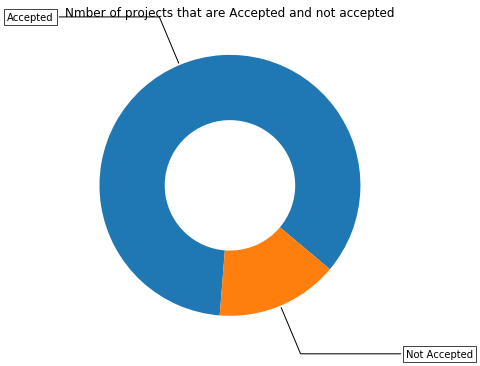

In [7]:
y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

from above results we can see that by visually and numerically that there are 85% of projects 
got funding and 15% of projects are nonfunding projects

In [9]:
#for each projects we need a multiple resources
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


here we can see the there are 1541272 resources whicih more than no of projects also there are
4 columns of resorces 'id' 'description' 'quantity' 'price'

In [10]:
resource_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541272 entries, 0 to 1541271
Data columns (total 4 columns):
id             1541272 non-null object
description    1540980 non-null object
quantity       1541272 non-null int64
price          1541272 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 47.0+ MB


In [11]:
resource_data.describe()

,quantity,price
count,1.541272e+06,1.541272e+06
mean,2.860509e+00,5.028398e+01
std,7.570345e+00,1.447326e+02
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,7.900000e+00
50%,1.000000e+00,1.499000e+01
75%,2.000000e+00,3.980000e+01
max,8.000000e+02,9.999000e+03


# 1.2.1 Univariate Analysis: School State

In [12]:
#for univariate analysis we are trying to get codes.
#by searching different code and moifying it we putting here by giving citation to all search query

# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

'''# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')
'''

'# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620\n\nscl = [[0.0, \'rgb(242,240,247)\'],[0.2, \'rgb(218,218,235)\'],[0.4, \'rgb(188,189,220)\'],            [0.6, \'rgb(158,154,200)\'],[0.8, \'rgb(117,107,177)\'],[1.0, \'rgb(84,39,143)\']]\n\ndata = [ dict(\n        type=\'choropleth\',\n        colorscale = scl,\n        autocolorscale = False,\n        locations = temp[\'state_code\'],\n        z = temp[\'num_proposals\'].astype(float),\n        locationmode = \'USA-states\',\n        text = temp[\'state_code\'],\n        marker = dict(line = dict (color = \'rgb(255,255,255)\',width = 2)),\n        colorbar = dict(title = "% of pro")\n    ) ]\n\nlayout = dict(\n        title = \'Project Proposals % of Acceptance Rate by US States\',\n        geo = dict(\n            scope=\'usa\',\n            projection=dict( type=\'albers usa\' ),\n            showlakes = True,\n            lakecolor = \'rgb(255, 255, 255)\',\n        ),\n    )\n\nfig = go.Figure(data=dat

In [13]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


# Summary
1-from above information we observe that Delaware(DE)has the highest percentage of project 
acceptance having approximately 90% acceptance rate sucseeded by North Dakota(ND)and Washington(WA) neaarly y 89% & 88% respectively

2-Also we could obsererved that Vermount is the lowest approval rated state by exactly 80% followed by District of coloumbia (DC) and Texas(TX) with nearly 80% and 81% respectively
3-Avg approval rate is 855 but here we getting respective state percentages  upeer Five showing states with lower approval rate and bottom five showing states with higher approval rate

In [14]:
# now we are going to run some fuctions to get stacked bar plots
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [15]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

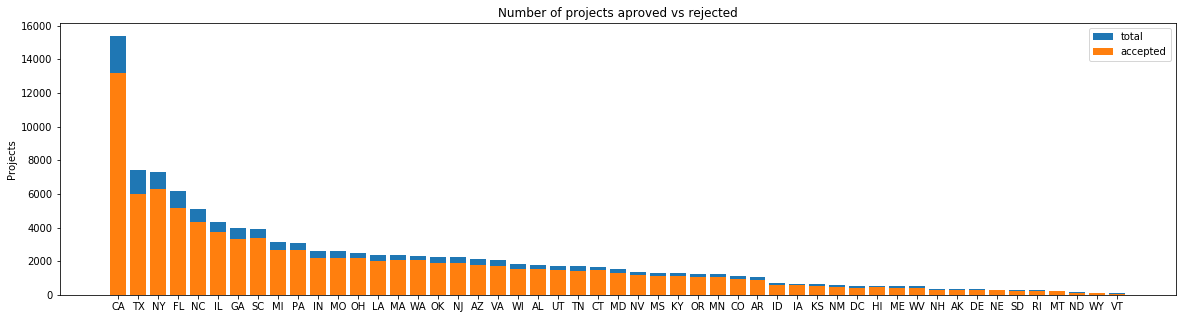

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [16]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

##### SUMMARY :
1. Every state has greater than 80% success rate in approval.
2. There is a lot of variability in the number of projects that have been submitted across the
States.
3. California(CA) has the highest number of project proposals when compared to the other
states, Surprisingly, 85% of the projects gets approved on an average which is nearly 13205 out
of 15388 project proposals.
4. Vermont(VT) has the lowest number of project proposals initiated (80) and almost 80% of the
project proposal gets acceptance (64 out of 80). Well, in terms of rejection only 16 were
rejected.

# 1.2.2 Univariate Analysis: teacher_prefix

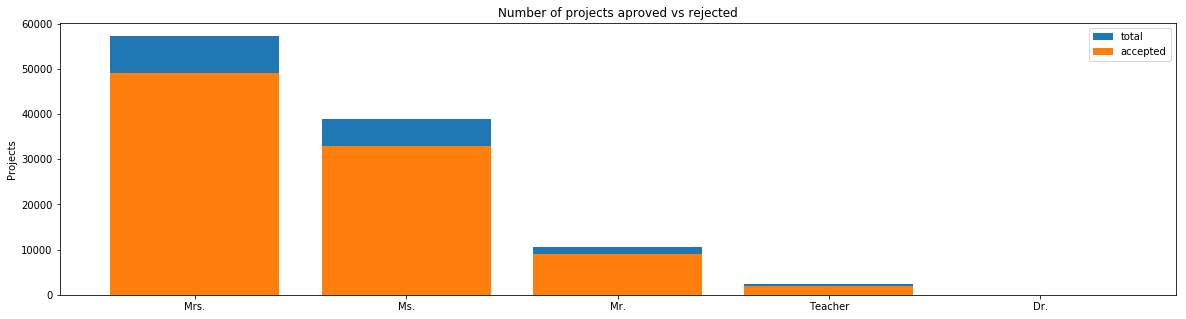

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [17]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

### SUMMARY :
1. Female Teachers have the maximum number of projects proposed and accepted compared to
the male teachers.
2. Teachers with prefixes Mrs. , which means Married Women as teachers have a higher number
of projects Proposed as well as Accepted when compared to the younger Unmarried Women
Teachers.
3. Teachers with Dr. title have proposed hardly 13 projects and out of which 9 of them have been
approved.

# 1.2.3 Univariate Analysis: project_grade_category

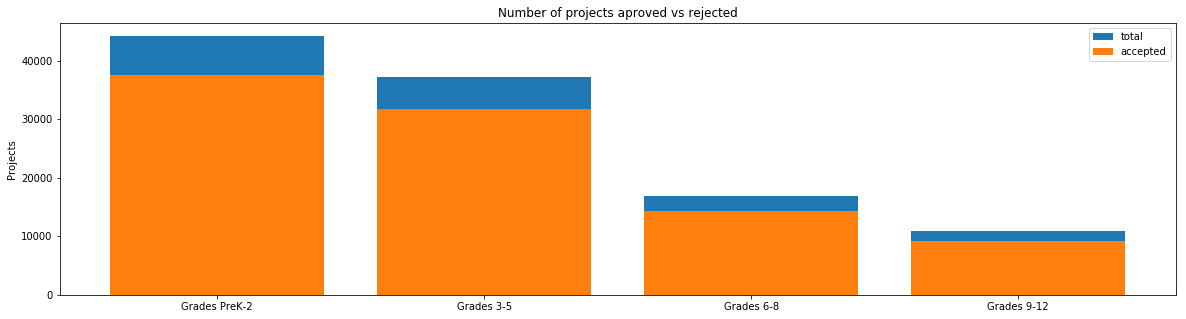

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [18]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

### SUMMARY :
1. There are alot of projects proposed for the students between Pre Kindergarden and 2nd
Grade while for the rest it keeps decreasing.
2. The average Acceptance rate of the project is 84% irrespective of the Grade.
3. We also notice that Students between the 9th Grade and 12th Grade have the lowest number
of projects proposed as well as accepted.

# 1.2.4 Univariate Analysis: project_subject_categories

In [19]:
#by following the below code we are doing simple  Text Preprocessing
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [20]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports


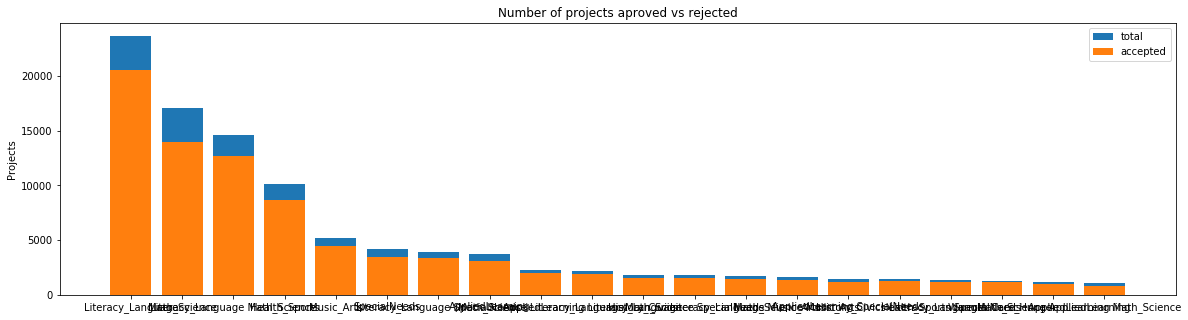

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [21]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

### SUMMARY :

1. Projects belonging to the Literacy and Language categories have the highest number of
projects proposed under. The maximum number of accepted projects also belong to this
category, having an acceptance rate of nearly 87%.
2. Projects belonging to both Maths and Science have acceptance rate of nearly 82% while
introducing the concept of Literacy and Language to this can increase its accpetance rate to
nearly 87%
3. There is a lot of variablity in the total number of projects proposed per Category of the
project.
4. Projects belonging to both Maths and Science when combined with Applied Learning has the
least number of projects proposed as well approved.
5. There is also Variability in Acceptance rate, projects under the category Warmth, Care and
Hunger have an acceptance rate of 93.5%

In [22]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

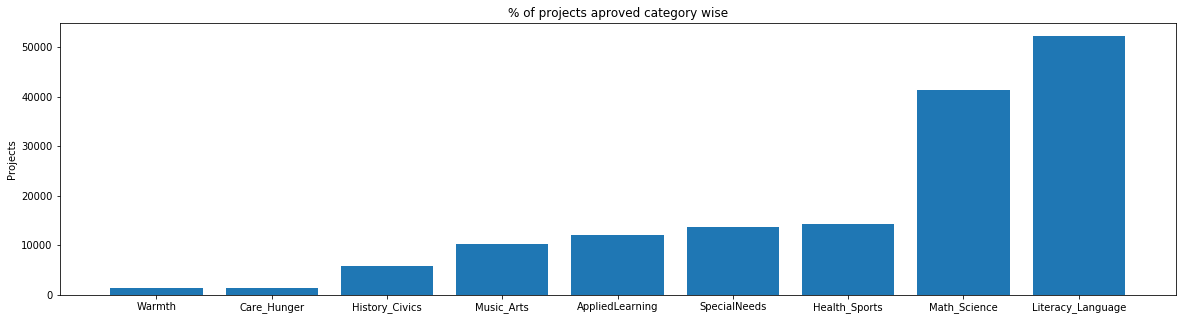

In [23]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [24]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


### SUMMARY

###### 1. The highest number of projects are registered under Literacy and Language with 52,239 projects, followed by Maths and Science having 41,421 projects.
2. There are only 1388 projects under the category of Warmth , Care or Hunger.

## 1.2.5 Univariate Analysis: project_subject_subcategories

In [25]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [26]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports


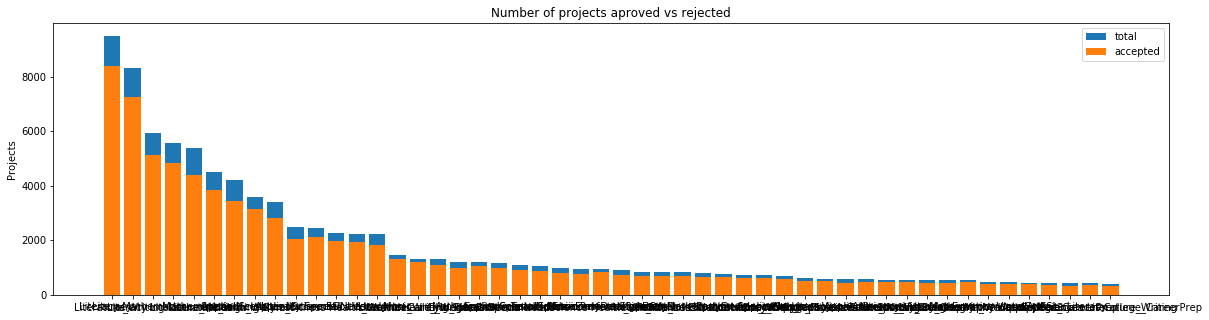

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [27]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

##### SUMMARY :
1. The sub-Category Literacy has the highest number of projects approved with 8371 projects.
Also the acceptance rate is 88%.
2. The sub-Category Health and Wellness have the lowest number of projects proposed with
3,583 projects only.

In [28]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

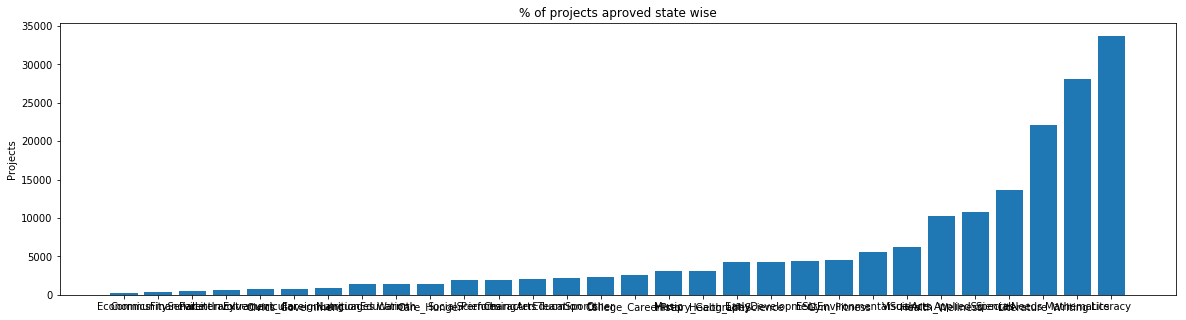

In [29]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [30]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


#### Summary:

1.The largest amount of projects are recorded with 33700 & 28074 projects in Literacy and Mathematics followed by 22179 projects in Literature_Writing.

2.In the Economics(269)and CommunityService (441) recorded very low projects among all subjects.

### 1.2.6 Univariate Analysis: Text features (Title)

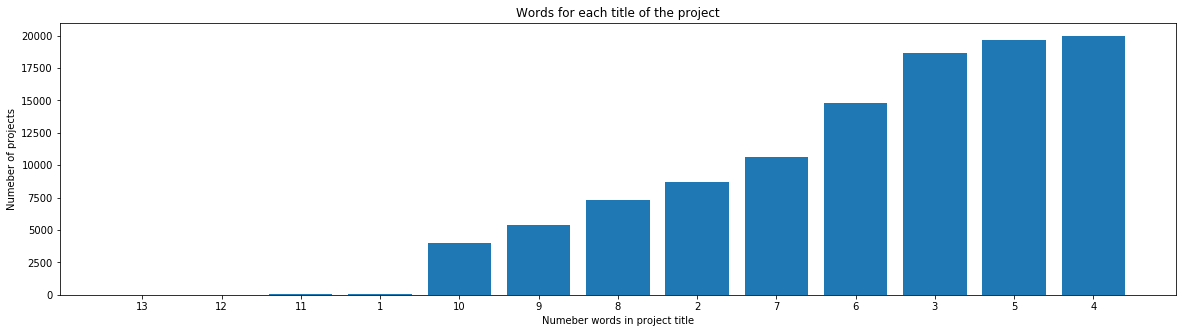

In [31]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

#### SUMMARY :
1. Most of the projects have 4 words in the title.
2. Roughly most of the projects have 3, 4 or 5 words in the title.
3. There are hardly any project titles containing more than 10 words and single word

In [32]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

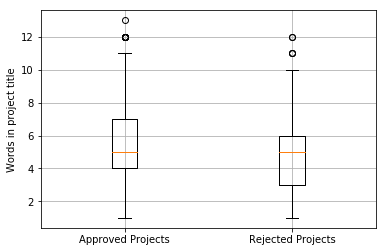

In [33]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

### Summary:

    1-From above box plot we can see that boxplot for approved projects is slightly higher           than rejected projects althogh median of both plots coincides slighltly.
    
    2- The no of words in approved projects are slighltly more than rejected projects

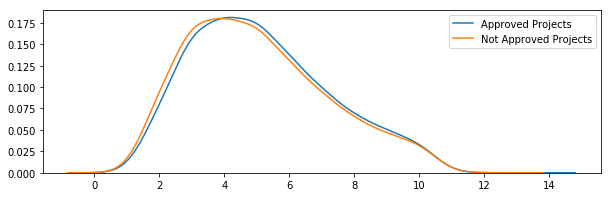

In [34]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

### Summary:

    1-This is the PDF of no of words in Title.Blue line indicates Project aprroved curve
      and orange line shows projects not approved curve.
    
    2-From PDf graph we can observe that blue line is slighltly ahead orange line which
      means no of words are more in approved projects than not approved

### 1.2.7 Univariate Analysis: Text features (Project Essay's)¶

In [35]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [36]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

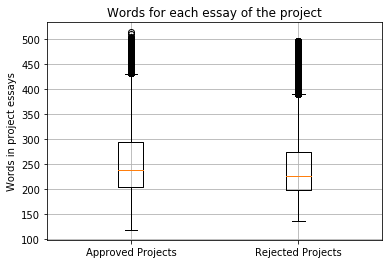

In [38]:
#we choose the following code to find the no of words in essays
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

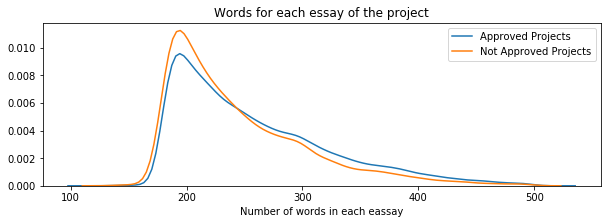

In [39]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

### SUMMARY :
 From both the plot it is clear that the number of Projects approved have a slightly more number of words in the Title when compared to the Rejected Projects. The Boxplots use the Percentiles while the above graph used Probability densities.

### 1.2.8 Univariate Analysis: Cost per project

In [40]:
# we get the cost of the project using resource.csv file
resource_data.head(3)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45


In [41]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [42]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [43]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

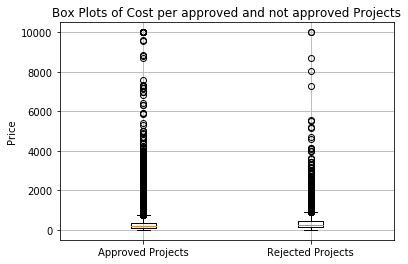

In [44]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

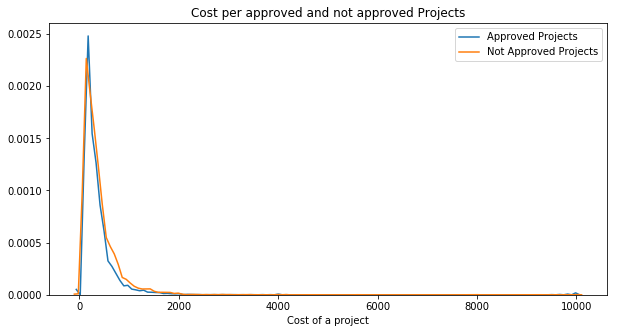

In [45]:
plt.figure(figsize=(10,5))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()


### Summary:
    Not much can be understood from the box plot depicting the Cost involved per project. We can generalise from the PDF curves that mostly Projects that are very costly are usually not approved.

In [48]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

### SUMMARY :
1. The approved projects tend to have lower cost when compared to the projects that have not
been approved. This can be noticed by looking at the percentile values. The 50th percentile Cost
value for an approved project is 199 dollars while for the cost for the not approved projects is
263 dollars.
2. The Maximum price for any project should be less than 10,000 dollars.
3. Typically, any approved Project costs less than the that of the Projects not approved across
the spectrum of Percentiles.

### 1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects

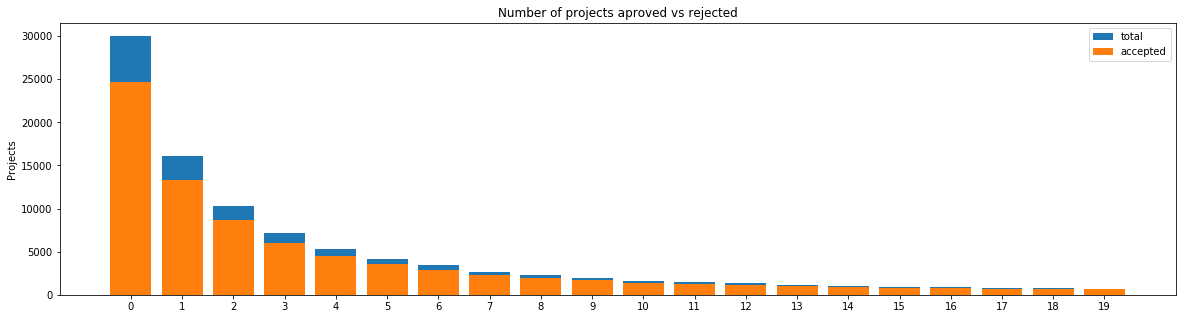

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
    teacher_number_of_previously_posted_projects  project_is_approved  total  \
15                                            15                  818    942   
16                                            16                  769    894   
17                                            17                  712    803   
18                                            18                  666    772   
19                                       

In [49]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects',
'project_is_approved', top=20)

### SUMMARY :
1. There is alot of variability in the number of projects previously proposed by the teacher
varying from 0 to more than 20.
2. We observe that it is not mandatory for a teacher to have proposed any project prior.
Maximum number of teachers, nearly 82% of the approved projects have been submitted by
teachers with no prior project proposals. New talent and efforts are well appreciated.
3. Very few teachers who have proposed more than 20 projects have got approval. But the rate
of approval is Higher given the teacher has proposed atleast 19 different projects.

### 1.2.10 Univariate Analysis: project_resource_summary

In [50]:
## Let us separate the data and carry out our work only on the required Project Resource Summaries

summaries = []
for a in project_data["project_resource_summary"] :summaries.append(a)
summaries[0:10]

['My students need opportunities to practice beginning reading skills in English at home.',
 'My students need a projector to help with viewing educational programs',
 'My students need shine guards, athletic socks, Soccer Balls, goalie gloves, and training materials for the upcoming Soccer season.',
 'My students need to engage in Reading and Math in a way that will inspire them with these Mini iPads!',
 'My students need hands on practice in mathematics. Having fun and personalized journals and charts will help them be more involved in our daily Math routines.',
 'My students need movement to be successful. Being that I have a variety of students that have all different types of needs, flexible seating would assist not only these students with special needs, but all students.',
 'My students need some dependable laptops for daily classroom use for reading and math.',
 'My students need ipads to help them access a world of online resources that will spark their interest in learning.',

In [ ]:
The length of the obtained list of Project summaries should match the total number of project s
ummaries in the project data

In [51]:

len(summaries)

109248

In [52]:
###### Identifying the numbers from the project summaries and storing the values as a key valupair in a dictionary to avoid the position of the value within huge value of summary data

numeric_summary_values = {}
for x in tqdm(range(len(summaries))):
    for s in summaries[x].split():
        if s.isdigit:
            numeric_summary_values[x] = int()

100%|███████████████████████████████| 109248/109248 [00:01<00:00, 73690.33it/s]


In [53]:
numeric_summary_values[14]

0

In [54]:
# now we have only key values pairs for summaries containing numeric value,so
numeric_digits = {}
for c in range(len(summaries)):
    if c in numeric_summary_values.keys():
        numeric_digits[c]= numeric_summary_values[c]
    else:
        numeric_digits[c]=0
        
    
        

In [55]:
len(numeric_digits)

109248

In [56]:
## Converting the key value pairs to 1 or 0 based on presence of Numeric Values.
digit_in_summary = []

for a in numeric_digits.values():
    if a > 0 :
        digit_in_summary.append(1)
    else :
        digit_in_summary.append(0)


In [57]:
digit_in_summary[0:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [58]:
project_data['digit_in_summary']= digit_in_summary

In [59]:
project_data.head(20)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,...,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity,digit_in_summary
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",...,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...,154.60,23,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,...,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...,299.00,1,0
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,...,NaN,"My students need shine guards, athletic socks,...",1,0,Health_Sports,Health_Wellness TeamSports,"\r\n\""True champions aren't always the ones th...",516.85,22,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,...,NaN,My students need to engage in Reading and Math...,4,1,Literacy_Language Math_Science,Literacy Mathematics,I work at a unique school filled with both ESL...,232.90,4,0
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",...,NaN,My students need hands on practice in mathemat...,1,1,Math_Science,Mathematics,Our second grade classroom next year will be m...,67.98,4,0
5,141660,p154343,a50a390e8327a95b77b9e495b58b9a6e,Mrs.,FL,2017-04-08 22:40:43,Grades 3-5,Flexible Seating for Mrs. Jarvis' Terrific Thi...,I will be moving from 2nd grade to 3rd grade a...,These flexible seating options will allow my s...,...,NaN,My students need movement to be successful. Be...,1,1,Literacy_Language SpecialNeeds,Literature_Writing SpecialNeeds,I will be moving from 2nd grade to 3rd grade a...,113.22,11,0
6,21147,p099819,9b40170bfa65e399981717ee8731efc3,Mrs.,CT,2017-02-17 19:58:56,Grades 6-8,Chromebooks for Special Education Reading Program,My students are a dynamic and very energetic g...,My students are an engaging and active group o...,...,NaN,My students need some dependable laptops for d...,1,1,Literacy_Language SpecialNeeds,Literacy SpecialNeeds,My students are a dynamic and very energetic g...,159.99,3,0
7,94142,p092424,5bfd3d12fae3d2fe88684bbac570c9d2,Ms.,GA,2016-09-01 00:02:15,Grades 3-5,It's the 21st Century,Not only do our students struggle with poverty...,"My students need 4 iPads, the latest technolog...",...,NaN,My students need ipads to help them access a w...,7,1,Math_Science,Mathematics,Not only do our students struggle with poverty...,229.00,4,0
8,112489,p045029,487448f5226005d08d36bdd75f095b31,Mrs.,SC,2016-09-25 17:00:26,Grades PreK-2,Targeting More Success in Class,My students are enthusiastic and inquisitive l...,My second graders need extra activity time dur...,...,NaN,My students need three devices and three manag...,28,1,Health_Sports,Health_Wellness,My students are enthusiastic and inquisitive l...,241.98,6,0
9,158561,p001713,140eeac1885c820ad5592a409a3a8994,Ms.,NC,2016-11-17 18:18:56,Grades PreK-2,Just For the Love of Reading--\

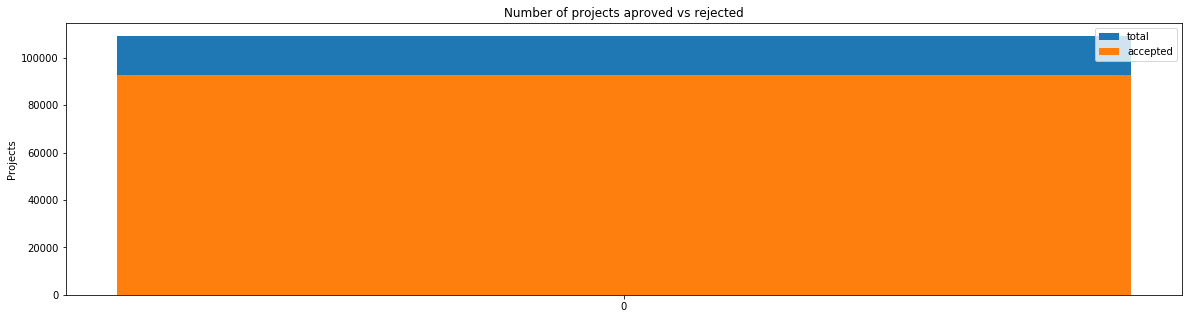

   digit_in_summary  project_is_approved   total       Avg
0                 0                92706  109248  0.848583
   digit_in_summary  project_is_approved   total       Avg
0                 0                92706  109248  0.848583


In [60]:
univariate_barplots(project_data,'digit_in_summary','project_is_approved',top=2)

# 1.3 Text preprocessing

### 1.3.1 Essay Text

In [61]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,...,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity,digit_in_summary
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",...,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...,154.6,23,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,...,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...,299.0,1,0


In [62]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)

My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [63]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [64]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [65]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [66]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [67]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords =['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [68]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|█████████████████████████████████| 109248/109248 [01:52<00:00, 970.03it/s]


In [69]:
# after preprocesing
preprocessed_essays[15000]

'you bring horse water not make drink however expose students world technology not able stop exploring how cool would children exposed simple technology ipad classroom my students reside small town hearts shape world they limited resources prepare real world it statistically proven students not prepared real world they might able text play game however skills needed capable surviving work force today involve technology integration among multiple curricula science technology reading multimedia it integral part students education tools capable striving advanced learning environment assist providing appropriate instruction effectively my students opportunity exposure endless resources simply not available classroom computer it said app everything i mind blown amount educational apps available educators students apps allow student developmental disability effectively communicate classroom teacher device need charged 24 7 app serve additional means instruction literacy centers 100 full enga

### 1.3.2 Project title Text

In [70]:
# printing some random essays.
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)
print(project_data['project_title'].values[20000])
print("="*50)
print(project_data['project_title'].values[99999])
print("="*50)

Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year
We Need To Move It While We Input It!
Inspiring Minds by Enhancing the Educational Experience


In [71]:
preprocessed_titles = []
for titles in tqdm(project_data["project_title"]):
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    title = ' '.join(f for f in title.split() if f not in stopwords)
    preprocessed_titles.append(title.lower().strip())

100%|███████████████████████████████| 109248/109248 [00:06<00:00, 18052.00it/s]


In [72]:
print(preprocessed_titles[0])
print("="*50)
print(preprocessed_titles[50])
print("="*50)
print(preprocessed_titles[500])
print("="*50)
print(preprocessed_titles[5000])
print("="*50)
print(preprocessed_titles[10000])
print("="*50)

educational support english learners home
be active be energized
classroom chromebooks college bound seniors
bouncing our wiggles worries away
family book clubs


# 1. 4 Preparing data for models

In [73]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'digit_in_summary'],
      dtype='object')

we are going to consider
   - school_state : categorical data
   - clean_categories : categorical data
   - clean_subcategories : categorical data
   - project_grade_category : categorical data
   - teacher_prefix : categorical data

   - project_title : text data
   - text : text data
   - project_resource_summary: text data

   - quantity : numerical
   - teacher_number_of_previously_posted_projects : numerical
   - price : numerical


#### 1.4.1 Vectorizing Categorical data

In [ ]:
#we will follow this link for vectorizing
#https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

In [75]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109248, 30)


#### school states


In [76]:
my_counter = Counter()
for state in project_data['school_state'].values:
    my_counter.update(state.split())

In [77]:
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [78]:
## we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False
, binary=True)
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())
school_state_categories_one_hot = vectorizer.transform(project_data['school_state'].values)
print("Shape of matrix after one hot encoding ",school_state_categories_one_hot.shape)

['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of matrix after one hot encoding  (109248, 51)


#### One hot encode Teacher Prefix

In [79]:
my_counter = Counter()
for teacher_prefix in project_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix)
    my_counter.update(teacher_prefix.split())

In [80]:
teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1])
)

## we use count vectorizer to convert the values into one hot encoded features unlike 
the previous catageries this catagery returns a value error :np.nan invalid document
ref-https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nanis-an-invalid-document/39308809#39308809



In [81]:
vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False,binary=True)
 
vectorizer.fit(project_data['teacher_prefix'].values.astype("U"))
print(vectorizer.get_feature_names())
teacher_prefix_categories_one_hot = vectorizer.transform(project_data['teacher_prefix'].values.astype("U"))
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot.shape)

['nan', 'Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']
Shape of matrix after one hot encoding  (109248, 6)


#### One Hot Encode - Project Grade Category

In [82]:
my_counter = Counter()
for project_grade in project_data['project_grade_category'].values:
    my_counter.update(project_grade.split())

In [83]:
project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[1]))

In [84]:
## we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())
project_grade_categories_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("Shape of matrix after one hot encoding ",project_grade_categories_one_hot.shape)


['9-12', '6-8', '3-5', 'PreK-2', 'Grades']
Shape of matrix after one hot encoding  (109248, 5)


### 1.4.2 Vectorizing Text data

#### 1.4.2 Vectorizing Text data

In [85]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (109248, 16623)


In [86]:
print("There are{} unique words among the {} number of Project essays,considering atleast 10 different projects has the same word".format(text_bow.shape[1],text_bow.shape[0])) 

There are16623 unique words among the 109248 number of Project essays,considering atleast 10 different projects has the same word


#### 1.4.2.2 Bag of Words on `project_title`

In [87]:
vectorizer = CountVectorizer(min_df=10)
title_bow = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encoding ",title_bow.shape)

Shape of matrix after one hot encoding  (109248, 3329)


In [88]:
print("There are{} unique words among the {} number of Project titles,considering atleast 10 different projects has the same word".format(text_bow.shape[1],text_bow.shape[0])) 

There are16623 unique words among the 109248 number of Project titles,considering atleast 10 different projects has the same word


#### 1.4.2.3 TFIDF vectorizer

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 16623)


#### 1.4.2.4 TFIDF Vectorizer on `project_title`

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
title_tfidf = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",title_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 3329)


#### 1.4.2.5 Using Pretrained Models: Avg W2V

In [91]:
'''
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!

# ============================

words = []
for i in preproced_texts:
    words.extend(i.split(' '))

for i in preproced_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


'''

'\n# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039\ndef loadGloveModel(gloveFile):\n    print ("Loading Glove Model")\n    f = open(gloveFile,\'r\', encoding="utf8")\n    model = {}\n    for line in tqdm(f):\n        splitLine = line.split()\n        word = splitLine[0]\n        embedding = np.array([float(val) for val in splitLine[1:]])\n        model[word] = embedding\n    print ("Done.",len(model)," words loaded!")\n    return model\nmodel = loadGloveModel(\'glove.42B.300d.txt\')\n\n# ============================\nOutput:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n\n# ============================\n\nwords = []\nfor i in preproced_texts:\n    words.extend(i.split(\' \'))\n\nfor i in preproced_titles:\n    words.extend(i.split(\' \'))\nprint("all the words in the coupus", len(words))\nwords = set(words)\nprint("the unique words in the coupus", len(words))\n\ninter_words = set(model.keys()).intersection(word

In [93]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [95]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays.append(vector)

print(len(avg_w2v_vectors_essays))
print(len(avg_w2v_vectors_essays[0]))

100%|████████████████████████████████| 109248/109248 [01:06<00:00, 1640.52it/s]


109248
300


#### 1.4.2.6 Using Pretrained Models: AVG W2V on `project_title`

In [96]:
avg_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title.append(vector)

print(len(avg_w2v_vectors_title))
print(len(avg_w2v_vectors_title[0]))

100%|███████████████████████████████| 109248/109248 [00:07<00:00, 14674.09it/s]


109248
300


#### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V

In [97]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [98]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_essay.append(vector)

print(len(tfidf_w2v_vectors_essay))
print(len(tfidf_w2v_vectors_essay[0]))

100%|█████████████████████████████████| 109248/109248 [09:26<00:00, 208.24it/s]


109248
300


#### 1.4.2.9 Using Pretrained Models: TFIDF weighted W2V on `project_title

In [99]:
# Similarly we can vectorize for title also
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


In [100]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_title.append(vector)

print(len(tfidf_w2v_vectors_title))
print(len(tfidf_w2v_vectors_title[0]))

100%|███████████████████████████████| 109248/109248 [00:10<00:00, 10761.39it/s]


109248
300


### 1.4.3 Vectorizing Numerical features

In [101]:
# after observing this: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


In [102]:
price_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

Summary :
1. We observe that on an average Each project costs nearly 298 Dollars. With a Standard
Deviation of 368 dollars. So , mostly majority of the projects are less than 1000 Dollars.

### Vectorizing - Quantity (Numerical Data)

In [103]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
quantity_scalar = StandardScaler()
quantity_scalar.fit(project_data['quantity'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {quantity_scalar.mean_[0]}, Standard deviation : {np.sqrt(quantity_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
quantity_standardized = quantity_scalar.transform(project_data['quantity'].values.reshape(-1, 1))


Mean : 16.965610354422964, Standard deviation : 26.182821919093175


In [104]:
quantity_standardized

array([[ 0.23047132],
       [-0.60977424],
       [ 0.19227834],
       ...,
       [-0.4951953 ],
       [-0.03687954],
       [-0.45700232]])

##### Summary :
1. The projects on an average require atleast 17 Different of similar items. We observe that the Price paid is generally for the purchase of these Items. Donors can choose on projects to
donate based on the Items provided to aid the Students of any Grade.

### Vectorizing - Number of Projects Proposed Previously by the Teacher
(Numerical Data)

In [105]:
prev_projects_scalar = StandardScaler()
## Finding the mean and standard deviation of this data
prev_projects_scalar.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print("Mean : {}".format(prev_projects_scalar.mean_[0]))
print("Standard deviation : {}".format(np.sqrt(prev_projects_scalar.var_[0])))
# Now standardize the data with above maen and variance.
prev_projects_standardized = prev_projects_scalar.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.153165275336848
Standard deviation : 27.77702641477403


In [106]:
prev_projects_standardized

array([[-0.40152481],
       [-0.14951799],
       [-0.36552384],
       ...,
       [-0.29352189],
       [-0.40152481],
       [-0.40152481]])

#### Summary:
    We observe that Teachers usually on a median propose atleast 11 completely different 
    projects.
    The Teachers area unit so actively seeking facilitate to help for the betterment
    of the students in their neighborhood.

### 1.4.4 Merging all the above features

•we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [107]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(price_standardized.shape)

(109248, 9)
(109248, 30)
(109248, 16623)
(109248, 1)


In [108]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
X.shape

(109248, 16663)

now we are going to use one of the most powerful technique for dimentiaonally reduction i.e.
t-SNE.which is very intuitively geometrically elegamnt solution for dimentionaly reduction for visualition of data basically tSNE is Neighbourhood Preserving Embedding


# 2.1 TSNE with `BOW` encoding of `project_title` feature (5000 Data Entries)

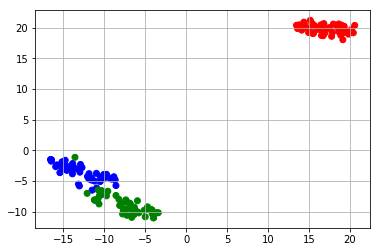

In [109]:
# https://github.com/pavlin-policar/fastTSNE
# http://colah.github.io/posts/2014-10-Visualizing-MNIST
# this is the example code for TSNE
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

iris = datasets.load_iris()
x = iris['data']
y = iris['target']
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.grid()
plt.show()

In [110]:
print("The Shape of Data matrices for Categorical Data are :")
print("\n")
print("The Shape of Data Matrix for different Categories of projects is :{}".format(categories_one_hot.shape))
print("The Shape of Data Matrix for different Sub-categories of projects is : {}".format(sub_categories_one_hot.shape))
print("The Shape of Data Matrix with respect to Projects from a particular State in the United States is : {}".format(school_state_categories_one_hot.shape))
print("The Shape of the Data Matrix of the different projects with respect to the Grades of the students is : {} ".format(project_grade_categories_one_hot.shape))
print("The Shape of the Data Matrix with respect to title of the Teacher proposing the Teacher is: {}".format(teacher_prefix_categories_one_hot.shape))
print("\n")
print("="*100)
print("\n")
print("The Shape of Data matrices for Numerical Data are :")
print("\n")
print("The Shape of the Data Matrix for price of the projects is : {}".format(price_standardized.shape))
print("The Shape of the Data Matrix for Quantity of the items for the projects is : {}".format(quantity_standardized.shape))
print("The Shape of the Data Matrix for the Number of Projects Proposed Previously by the Teacher is : {}".format(prev_projects_standardized.shape))
print("\n")
print("="*100)
print("\n")
print("TITLE BOW : {}".format(title_bow.shape))
print("\n")
print("TITLE TFIDF : {}".format(title_tfidf.shape))
print("\n")
print("TITLE AVG W2V : ({}, {})".format(len(avg_w2v_vectors_title), len(avg_w2v_vectors_title[0])))
print("\n")
print("TITLE TFIDF W2V : ({}, {})".format(len(tfidf_w2v_vectors_title),len(tfidf_w2v_vectors_title[0])))

The Shape of Data matrices for Categorical Data are :


The Shape of Data Matrix for different Categories of projects is :(109248, 9)
The Shape of Data Matrix for different Sub-categories of projects is : (109248, 30)
The Shape of Data Matrix with respect to Projects from a particular State in the United States is : (109248, 51)
The Shape of the Data Matrix of the different projects with respect to the Grades of the students is : (109248, 5) 
The Shape of the Data Matrix with respect to title of the Teacher proposing the Teacher is: (109248, 6)




The Shape of Data matrices for Numerical Data are :


The Shape of the Data Matrix for price of the projects is : (109248, 1)
The Shape of the Data Matrix for Quantity of the items for the projects is : (109248, 1)
The Shape of the Data Matrix for the Number of Projects Proposed Previously by the Teacher is : (109248, 1)




TITLE BOW : (109248, 3329)


TITLE TFIDF : (109248, 3329)


TITLE AVG W2V : (109248, 300)


TITLE TFIDF W2V : (109248,

In [111]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot,
project_grade_categories_one_hot, teacher_prefix_categories_one_hot, price_standardized,
quantity_standardized, prev_projects_standardized, title_bow))
X.shape

(109248, 3433)

In [112]:
from sklearn.manifold import TSNE
X = X.tocsr()
X_new = X[0:5000,:]

In [113]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_b = model.fit_transform(X_new)

In [114]:
labels = project_data["project_is_approved"]
labels_new = labels[0: 5000]
len(labels_new)

5000

In [115]:
tsne_data_b = np.vstack((tsne_data_b.T, labels_new)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))

In [116]:
tsne_df_b.shape

(5000, 3)

## 2.1 TSNE with `BOW` encoding of `project_title` feature 

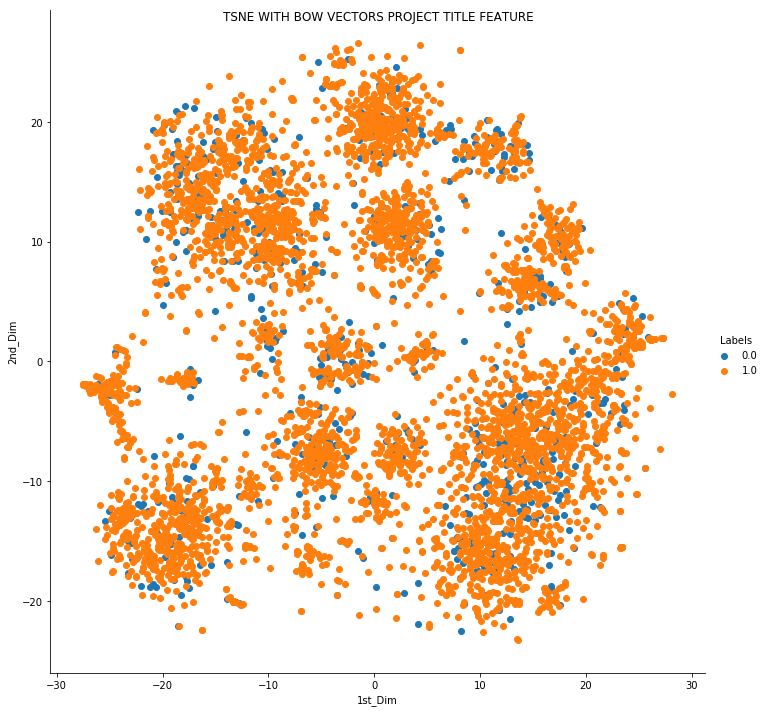

In [117]:
sns.FacetGrid(tsne_df_b, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim")\
.add_legend().\
fig.suptitle("TSNE WITH BOW VECTORS PROJECT TITLE FEATURE")
plt.show()

Summary :
1. We can see that from above plot most of overlapping in the datapoints.
2. The points are well scattered, unable to draw any proper conclusion.

## 2.2 TSNE with `TFIDF` encoding of `project_title` feature (5000 Data Entries)

In [118]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot,
project_grade_categories_one_hot, teacher_prefix_categories_one_hot, price_standardized,
quantity_standardized, prev_projects_standardized, title_tfidf))
X.shape

(109248, 3433)

In [119]:
X = X.tocsr()
X_new = X[0:5000,:]

In [120]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_tfidf = model.fit_transform(X_new)

In [121]:
tsne_data_tfidf = np.vstack((tsne_data_tfidf.T, labels_new)).T
tsne_df_tfidf = pd.DataFrame(tsne_data_tfidf, columns = ("1st_Dim","2nd_Dim","Labels"))

In [122]:
tsne_df_tfidf.shape

(5000, 3)

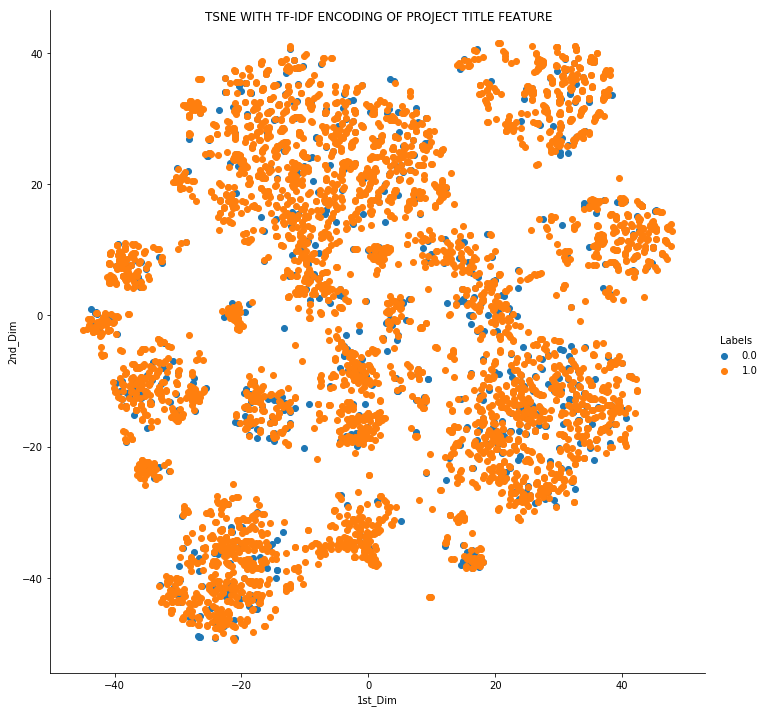

In [123]:
sns.FacetGrid(tsne_df_tfidf, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").\
add_legend().fig.suptitle("TSNE WITH TF-IDF ENCODING OF PROJECT TITLE FEATURE")
plt.show()

### Summary :
The Blue and the Orange points do not form any clusters or accumulation of any type, Hence
drawing conclusions seems to quite impossible with the current state of the T-SNE data using
TF - IDF Encoding.No conclusion can be find out

## 2.3 TSNE with `AVG W2V` encoding of `project_title` feature (5000 Data Entries)

In [125]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot,
project_grade_categories_one_hot,\
teacher_prefix_categories_one_hot, price_standardized, quantity_standardized, prev_projects_standardized,avg_w2v_vectors_title))
X.shape


(109248, 404)

In [126]:
X = X.tocsr()
X_new = X[0:5000,:]

In [127]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_avg_w2v = model.fit_transform(X_new)

In [128]:
tsne_data_avg_w2v = np.vstack((tsne_data_avg_w2v.T, labels_new)).T
tsne_df_avg_w2v = pd.DataFrame(tsne_data_avg_w2v, columns = ("1st_Dim","2nd_Dim","Labels"))

In [129]:
tsne_df_avg_w2v.shape

(5000, 3)

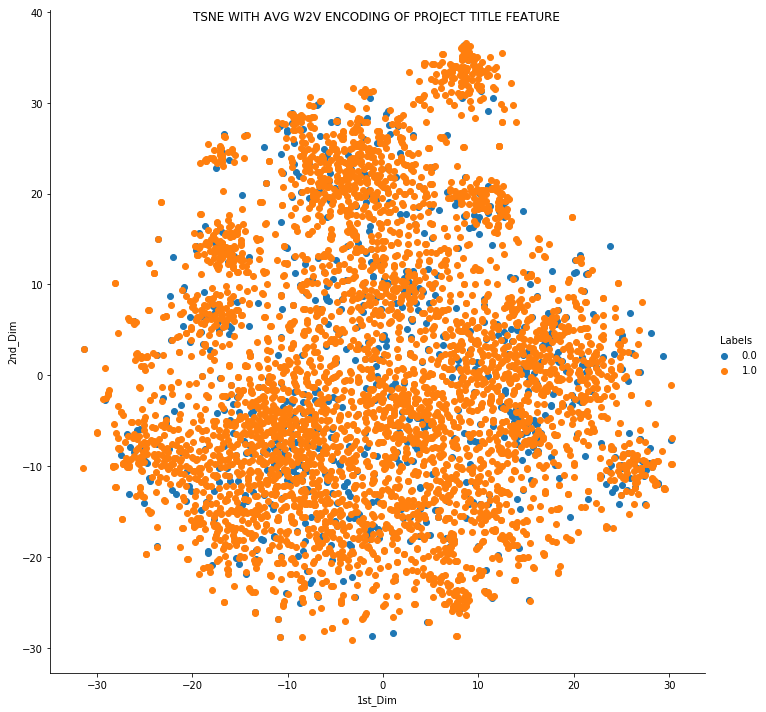

In [130]:
sns.FacetGrid(tsne_df_avg_w2v, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").\
add_legend().fig.suptitle("TSNE WITH AVG W2V ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

### Summary :
We cant observe any clusters for whether the Project is accepted or not accepted. Hence we
are not able to achieve the desired result using Avg- Word2vec

## 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature (5000)

In [131]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot,
project_grade_categories_one_hot, teacher_prefix_categories_one_hot, price_standardized,
quantity_standardized, prev_projects_standardized, tfidf_w2v_vectors_title))
X.shape

(109248, 404)

In [132]:
X = X.tocsr()
X_new = X[0:5000,:]

In [133]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_tfidf_w2v = model.fit_transform(X_new)

In [134]:
tsne_data_tfidf_w2v = np.vstack((tsne_data_tfidf_w2v.T, labels_new)).T
tsne_df_tfidf_w2v = pd.DataFrame(tsne_data_tfidf_w2v, columns = ("1st_Dim","2nd_Dim","Labels"))

In [135]:
tsne_df_tfidf_w2v.shape

(5000, 3)

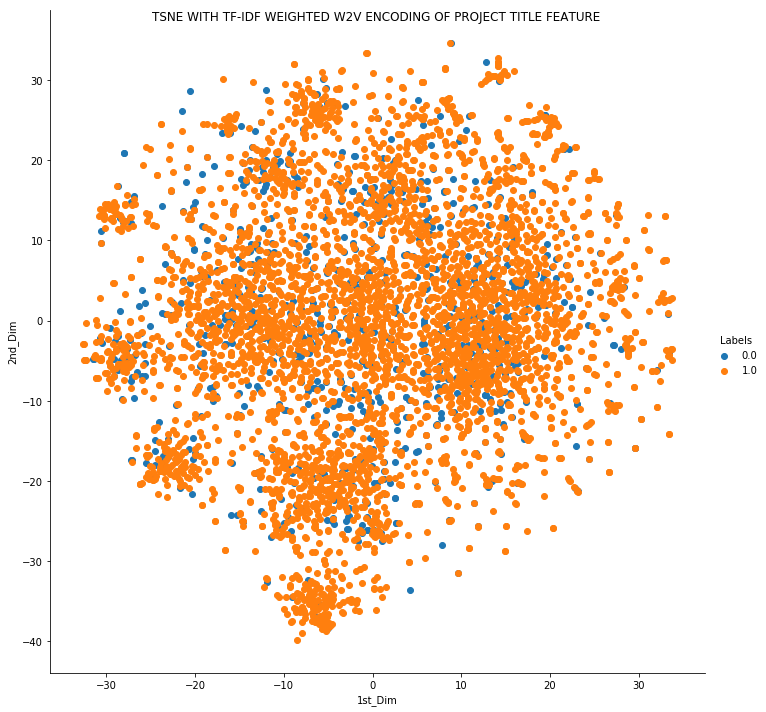

In [137]:
sns.FacetGrid(tsne_df_tfidf_w2v, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").\
add_legend().fig.suptitle("TSNE WITH TF-IDF WEIGHTED W2V ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

### Summary :
This visualisation of TSNE with TF-IDF Weighted Word2Vec does not seem to yield the expected
result of clustering similar data points. Hence we would have to try any other method

## 2.5 TSNE with `BOW`, `TFIDF`, `AVG W2V`, `TFIDF Weighted W2V` encoding of `project_title` feature (5000 Data Entries)

In [140]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot,
project_grade_categories_one_hot, teacher_prefix_categories_one_hot, price_standardized,
quantity_standardized, prev_projects_standardized, title_bow, title_tfidf, avg_w2v_vectors_title,
tfidf_w2v_vectors_title))
X.shape

(109248, 7362)

In [141]:
X = X.tocsr()
X_new = X[0:5000,:]

In [142]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_complete = model.fit_transform(X_new)

In [143]:
tsne_data_complete = np.vstack((tsne_data_complete.T, labels_new)).T
tsne_df_complete = pd.DataFrame(tsne_data_complete, columns = ("1st_Dim","2nd_Dim","Labels"))

In [144]:
tsne_df_complete.shape

(5000, 3)

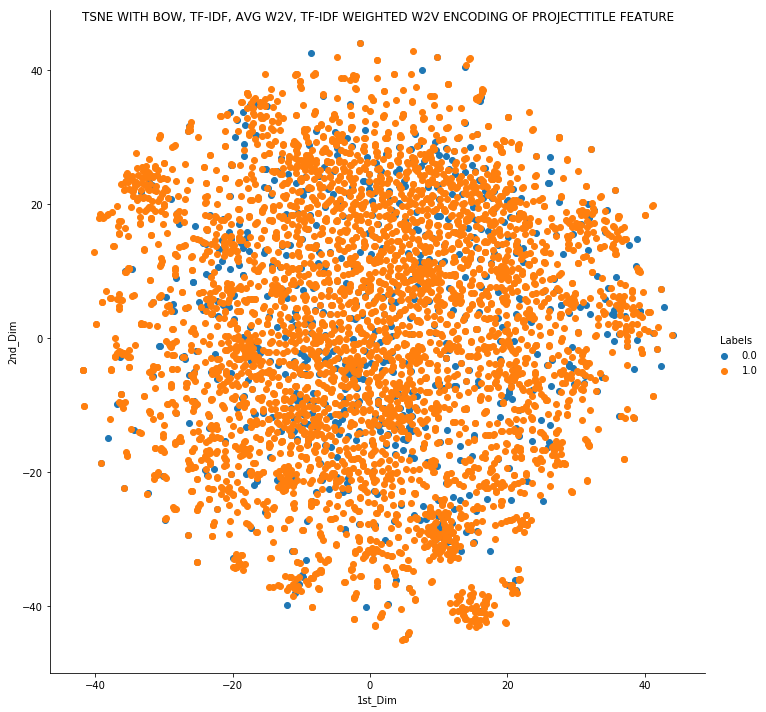

In [147]:
sns.FacetGrid(tsne_df_complete, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").\
add_legend().fig.suptitle("TSNE WITH BOW, TF-IDF, AVG W2V, TF-IDF WEIGHTED W2V ENCODING OF PROJECT\
TITLE FEATURE")
plt.show()

### Summary :
This visualisation of TSNE with Bag of Words, TF-IDF, Avg Word2Vec, TF-IDF Weighted
Word2Vec does not seem to yield the expected result of clustering similar data points. Hence we would have to try any other method.

## 2.6 CONCLUSION

## From above Observations we can Conclude that
1-Averageky there were 85% of projects from total projects are approved (got funding) while remaining 15% are non funding

2-Delaware (DE) state from the United States has the highest percent of projects accepted
within the whole country having almost 90% acceptance rate, followed by North Dakota (ND) and
Washington(WA) nearly 89% and 88% respectively each.

3-Vermont(VT) has the lowest Approval rate with exactly 80% followed by District of Columbia
(DC) and Texas(TX) with nearly 80% and 81% respectively.

4-California has supermassive no of project proposals nearly 85% whereas Vermount has low 80%

5-Female Teachers have the maximum number of projects proposed and accepted compared to the male teachers.

6-There are alot of projects proposed for the students between Pre Kindergarden and 2nd Grade
while for the rest it keeps decreasing.

7-The average Acceptance rate of the project is 84% irrespective of the Grade

8-Projects belonging to the Literacy and Language categories have the highest number of 
projects proposed under. The maximum number of accepted projects also belong to this category,
having an acceptance rate of nearly 87%.

9-There is a lot of variablity in the total number of projects proposed per Category of the 
project.

10-Projects belonging to both Maths and Science have acceptance rate of nearly 82% while
introducing the concept of Literacy and Language to this can increase its accpetance rate to
nearly 87%

11-There is also Variability in Acceptance rate, projects under the category Warmth, Care 
and Hunger have an acceptance rate of 93.5%.

12-The highest number of projects are registered under Literacy and Language with 52,239 
projects,followed by Maths and Science having 41,421 projects whereas2.There are only 1388
projects under the category of Warmth , Care or Hunger

13-The sub-Category Literacy has the highest number of projects approved with 8371 projects.
Also the acceptance rate is 88% whereas Health and Wellness have the lowest number of projects proposed with 3,583 projects only.

14-Roughly most of the projects have 3, 4 or 5 words in the title.There are hardly any project
titles containing more than 10 words

15-The number of words in the Project Essays of Approved Projects are slightly more than the
number of words in the Project Essays of the Rejected Projects.

16-The Maximum price for any project should be less than 10,000 dollars.The approved projects
tend to have lower cost when compared to the projects that have not been approved.

17-The authorized projects tend to have reduced costs compared to non-approved projects.
Looking at the percentile values,this can be noticed. For an approved project, the 50th 
percentile cost value is 198.99 dollars, while the cost for the unapproved projects is 263.145 dollars.

18-The project summaries containing numeric values have a very high acceptance rate of 90%.
Well,proper numbered requirements suggest clarity in the proposals and hence Alot of people
tend to donate for a better cause, that is to help children.

19-We notice that an average cost almost 298 dollars each project, with a standard deviation of 368 dollars. So, most of the projects are less than 750 dollars.

20-We observe that on an average Each project costs nearly 298 Dollars. The Price paid is
generally for the purchase of the Items. The projects on an average require atleast 17 Different of similar items.

21-Visualisation of tSNE with Bag of Words, TF-IDF, Avg Word2Vec, TF-IDF Weighted
Word2Vec does not seem to yield the expected result of clustering similar data points.Hence we
 have to think other method of Data Analysis.
 